## Preprocessing

In [1]:
# !pip install keras_tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.9/128.9 kB 475.6 kB/s eta 0:00:00


In [2]:
# Import our dependencies
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd
import tensorflow as tf
import keras_tuner as kt
import matplotlib.pyplot as plt
from imblearn.over_sampling import RandomOverSampler

#  Import and read the charity_data.csv.
application_df = pd.read_csv("https://static.bc-edx.com/data/dl-1-2/m21/lms/starter/charity_data.csv")
application_df.head()

,EIN,NAME,APPLICATION_TYPE,AFFILIATION,CLASSIFICATION,USE_CASE,ORGANIZATION,STATUS,INCOME_AMT,SPECIAL_CONSIDERATIONS,ASK_AMT,IS_SUCCESSFUL
0,10520599,BLUE KNIGHTS MOTORCYCLE CLUB,T10,Independent,C1000,ProductDev,Association,1,0,N,5000,1
1,10531628,AMERICAN CHESAPEAKE CLUB CHARITABLE TR,T3,Independent,C2000,Preservation,Co-operative,1,1-9999,N,108590,1
2,10547893,ST CLOUD PROFESSIONAL FIREFIGHTERS,T5,CompanySponsored,C3000,ProductDev,Association,1,0,N,5000,0
3,10553066,SOUTHSIDE ATHLETIC ASSOCIATION,T3,CompanySponsored,C2000,Preservation,Trust,1,10000-24999,N,6692,1
4,10556103,GENETIC RESEARCH INSTITUTE OF THE DESERT,T3,Independent,C1000,Heathcare,Trust,1,100000-499999,N,142590,1


In [4]:
# Create a method that creates a new Sequential model with hyperparameter options
def variaty_hp_compilation(hp):
   # use number of input features (namely, number of columns in X_train) as a global variable, because the function is called by the API, not realy by us directly
    global n_input_features
    input_d=n_input_features

    # Create a Keras Sequential model
    nn_model=tf.keras.models.Sequential()

    # Allow kerastuner to decide activation function
    activation_f=hp.Choice('activation',['relu','tanh'])

    # Allow kerastuner to decide number of neurons in first layer
    nn_model.add(tf.keras.layers.Dense(units=hp.Int('first_units',min_value=10,max_value=40, step=10),activation=activation_f, input_shape=(input_d,)))

    # Allow kerastuner to decide number of hidden layers and neurons in hidden layers
    for i in range(1,hp.Int('num_layers',2,3)):
        nn_model.add(tf.keras.layers.Dense(units=hp.Int('units_'+str(i),min_value=1, max_value=30, step=5),activation=activation_f))

    # Add final layer
    nn_model.add(tf.keras.layers.Dense(units=1,activation='sigmoid'))

    # Compile the model
    nn_model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy'])
    return nn_model

In [5]:
# Create a function for binning categorical values by value counts
# categ_name and range_values are expected to be list of sets here, that represent name of bin(s) and ranges of their value counts
def replace_bins(df_column, categ_name, range_values):
    # create a series of category X count of values for the category
    val_c=df_column.value_counts()
    # Choose a cutoff value and create a list of classifications to be replaced
    for i in range(0,len(range_values)):
        classifications_to_replace=[index for index, count in val_c.items() if (count<=range_values[i][1])&(count>range_values[i][0])]
        # Replace in dataframe
        for cls in classifications_to_replace:
            df_column = df_column.replace(cls,categ_name[i])
    return df_column

In [6]:
# Drop the non-beneficial ID columns, 'EIN' and 'NAME'.
application_df.drop(['EIN','NAME','STATUS'], axis=1, inplace=True)

In [7]:
application_df.head(12)

,APPLICATION_TYPE,AFFILIATION,CLASSIFICATION,USE_CASE,ORGANIZATION,INCOME_AMT,SPECIAL_CONSIDERATIONS,ASK_AMT,IS_SUCCESSFUL
0,T10,Independent,C1000,ProductDev,Association,0,N,5000,1
1,T3,Independent,C2000,Preservation,Co-operative,1-9999,N,108590,1
2,T5,CompanySponsored,C3000,ProductDev,Association,0,N,5000,0
3,T3,CompanySponsored,C2000,Preservation,Trust,10000-24999,N,6692,1
4,T3,Independent,C1000,Heathcare,Trust,100000-499999,N,142590,1
5,T3,Independent,C1200,Preservation,Trust,0,N,5000,1
6,T3,Independent,C1000,Preservation,Trust,100000-499999,N,31452,1
7,T3,Independent,C2000,Preservation,Trust,10M-50M,N,7508025,1
8,T7,Independent,C1000,ProductDev,Trust,1-9999,N,94389,1
9,T5,CompanySponsored,C3000,ProductDev,Association,0,N,5000,0


In [8]:
# Determine the number of unique values in each column.
for i in application_df.columns:
    print(f'{i}: {application_df[i].nunique()}')

APPLICATION_TYPE: 17
AFFILIATION: 6
CLASSIFICATION: 71
USE_CASE: 5
ORGANIZATION: 4
INCOME_AMT: 9
SPECIAL_CONSIDERATIONS: 2
ASK_AMT: 8747
IS_SUCCESSFUL: 2


In [9]:
# Look at APPLICATION_TYPE value counts for binning
app_type_vc=application_df['APPLICATION_TYPE'].value_counts()
app_type_vc

T3     27037
T4      1542
T6      1216
T5      1173
T19     1065
T8       737
T7       725
T10      528
T9       156
T13       66
T12       27
T2        16
T25        3
T14        3
T29        2
T15        2
T17        1
Name: APPLICATION_TYPE, dtype: int64

In [10]:
# Create a bin for value counts less than 700
application_df['APPLICATION_TYPE'] = replace_bins(application_df['APPLICATION_TYPE'],['Other'],[(0,700)])
# Check to make sure binning was successful
application_df['APPLICATION_TYPE'].value_counts()

T3       27037
T4        1542
T6        1216
T5        1173
T19       1065
Other      804
T8         737
T7         725
Name: APPLICATION_TYPE, dtype: int64

In [11]:
# Look at CLASSIFICATION value counts for binning
classif_vc=application_df['CLASSIFICATION'].value_counts()
classif_vc

C1000    17326
C2000     6074
C1200     4837
C3000     1918
C2100     1883
         ...  
C4120        1
C8210        1
C2561        1
C4500        1
C2150        1
Name: CLASSIFICATION, Length: 71, dtype: int64

In [12]:
# You may find it helpful to look at CLASSIFICATION value counts >1
classif_vc[classif_vc>1]

C1000    17326
C2000     6074
C1200     4837
C3000     1918
C2100     1883
C7000      777
C1700      287
C4000      194
C5000      116
C1270      114
C2700      104
C2800       95
C7100       75
C1300       58
C1280       50
C1230       36
C1400       34
C7200       32
C2300       32
C1240       30
C8000       20
C7120       18
C1500       16
C1800       15
C6000       15
C1250       14
C8200       11
C1238       10
C1278       10
C1235        9
C1237        9
C7210        7
C2400        6
C1720        6
C4100        6
C1257        5
C1600        5
C1260        3
C2710        3
C0           3
C3200        2
C1234        2
C1246        2
C1267        2
C1256        2
Name: CLASSIFICATION, dtype: int64

In [13]:
# create 3 bins with value counts being respectively between 0 and 10, between 10 and 95, between 95 and 100
application_df['CLASSIFICATION'] = replace_bins(application_df['CLASSIFICATION'],['Hundreds','Tens','Ones'],[(95,500),(10,95),(0,10)])
# Check to make sure binning was successful
application_df['CLASSIFICATION'].value_counts()

C1000       17326
C2000        6074
C1200        4837
C3000        1918
C2100        1883
Hundreds      815
C7000         777
Tens          551
Ones          118
Name: CLASSIFICATION, dtype: int64

In [14]:
# Convert categorical data with only 2 unique values into 0 and 1
application_df['SPECIAL_CONSIDERATIONS']=(application_df['SPECIAL_CONSIDERATIONS']=='Y').astype(int)

In [15]:
# check value counts for 'INCOME_AMT' in order understand what ranges are here
i_a=application_df['INCOME_AMT'].value_counts()
i_a

0                24388
25000-99999       3747
100000-499999     3374
1M-5M              955
1-9999             728
10000-24999        543
10M-50M            240
5M-10M             185
50M+               139
Name: INCOME_AMT, dtype: int64

In [16]:
# import regex module in order to remove/substitute a sub-string by (\-|\+).* pattern
import re
# create a dictionary to keep original and updated ranges of amounts, which only contain min value of a range
repl_dict={}
for i in i_a.index:
    # replace M, so that all numbers here share same format
    i_r=i.replace("M","000000")
    # leave only min value of range (starting point)
    i_r=re.sub('(\-|\+).*','',i_r) # https://note.nkmk.me/en/python-str-remove-strip/#remove-substrings-by-regex-resub
    # add the converted min value to a dictionary
    repl_dict[i]=int(i_r)
repl_dict

{'0': 0,
 '25000-99999': 25000,
 '100000-499999': 100000,
 '1M-5M': 1000000,
 '1-9999': 1,
 '10000-24999': 10000,
 '10M-50M': 10000000,
 '5M-10M': 5000000,
 '50M+': 50000000}

In [17]:
# update the 'INCOME_AMT' column of original input data with min integer values and check the result
application_df['INCOME_AMT']=application_df['INCOME_AMT'].map(repl_dict)
application_df['INCOME_AMT'].value_counts()

0           24388
25000        3747
100000       3374
1000000       955
1             728
10000         543
10000000      240
5000000       185
50000000      139
Name: INCOME_AMT, dtype: int64

In [18]:
# check data at high level
application_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34299 entries, 0 to 34298
Data columns (total 9 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   APPLICATION_TYPE        34299 non-null  object
 1   AFFILIATION             34299 non-null  object
 2   CLASSIFICATION          34299 non-null  object
 3   USE_CASE                34299 non-null  object
 4   ORGANIZATION            34299 non-null  object
 5   INCOME_AMT              34299 non-null  int64 
 6   SPECIAL_CONSIDERATIONS  34299 non-null  int64 
 7   ASK_AMT                 34299 non-null  int64 
 8   IS_SUCCESSFUL           34299 non-null  int64 
dtypes: int64(4), object(5)
memory usage: 2.4+ MB


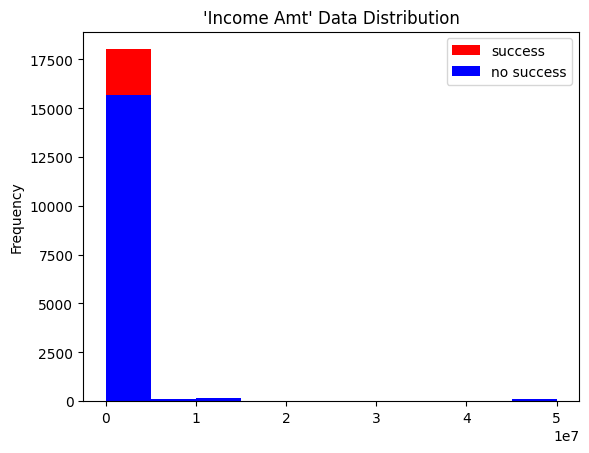

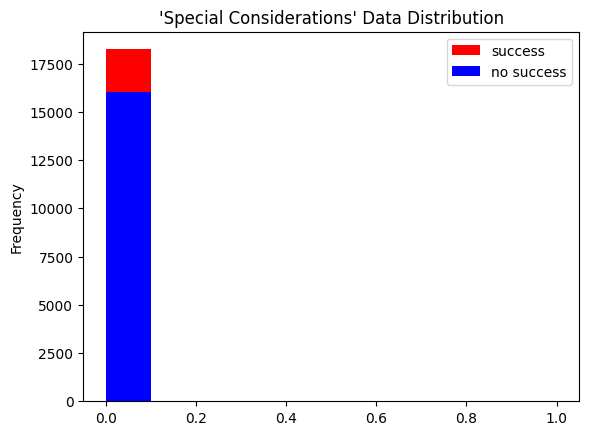

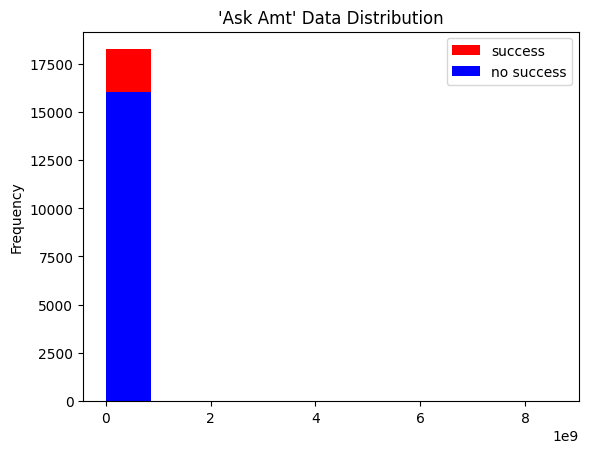

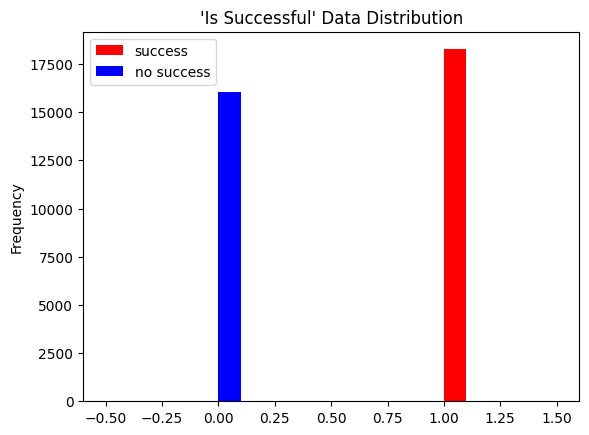

In [19]:
# plot numerical data
for i in application_df.columns[5:]:
    title=i.replace('_', ' ').title()
    application_df.loc[application_df['IS_SUCCESSFUL']==1,i].plot.hist(color='red', label='success')
    application_df.loc[application_df['IS_SUCCESSFUL']==0,i].plot.hist(color='blue', label='no success')
    plt.title(f"'{title}' Data Distribution")
    plt.legend()
    plt.show()

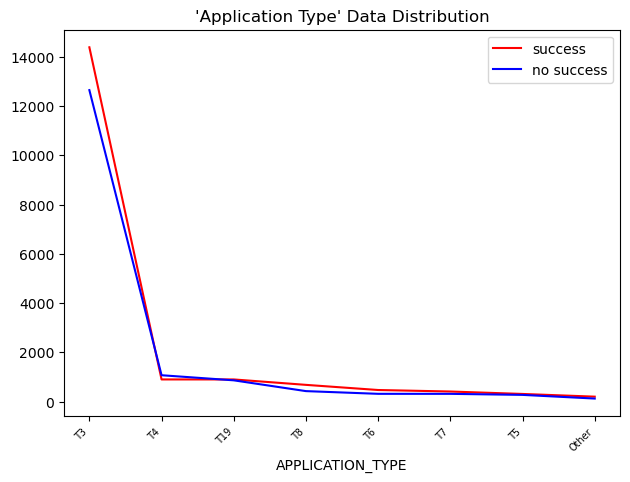

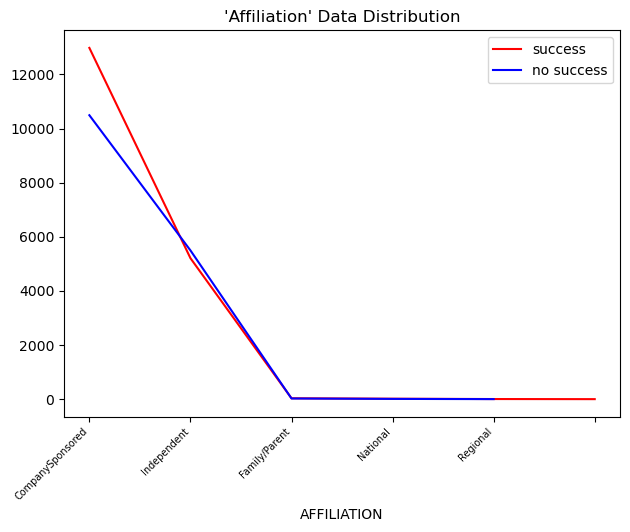

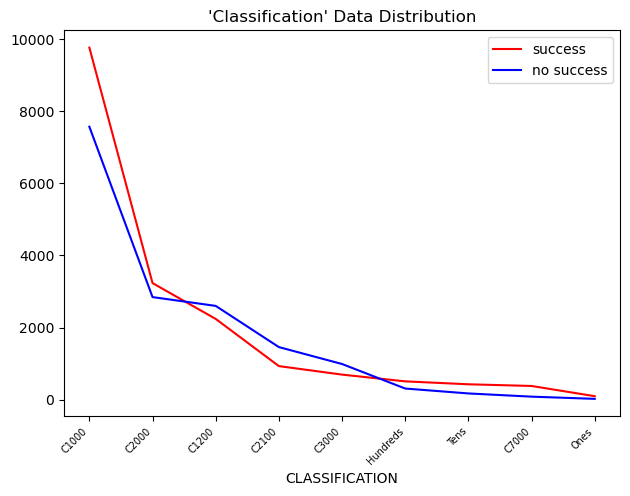

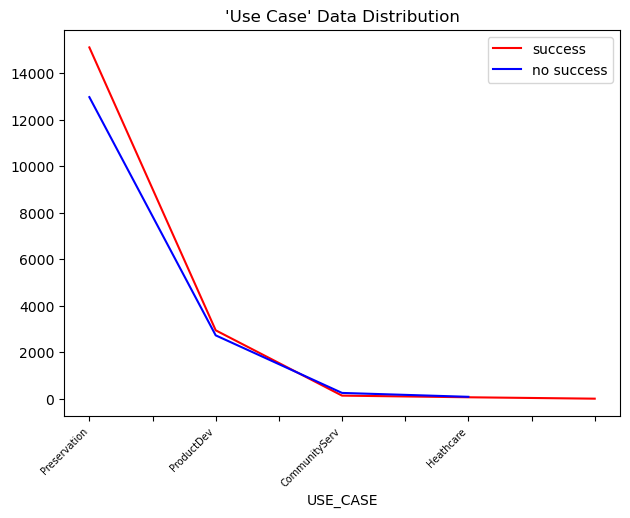

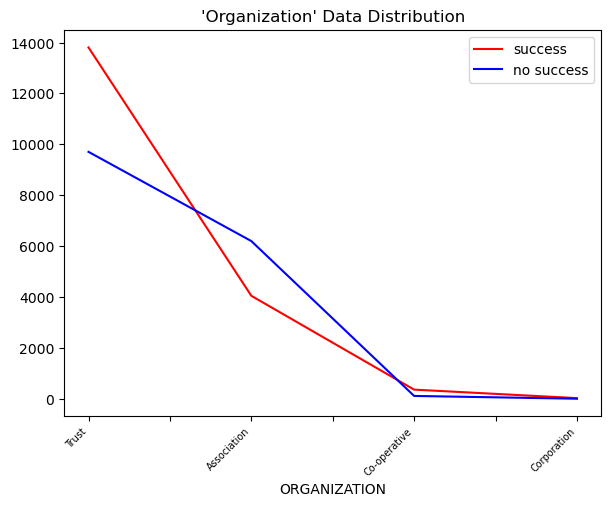

In [ ]:
# plot categorical data
for i in application_df.columns[:5]:
    title=i.replace('_', ' ').title()
    application_df.loc[application_df['IS_SUCCESSFUL']==1,i].value_counts().plot(color='red', label='success')
    application_df.loc[application_df['IS_SUCCESSFUL']==0,i].value_counts().plot(color='blue', label='no success')
    plt.title(f"'{title}' Data Distribution")
    plt.legend()
    plt.tight_layout()
    plt.xticks(rotation=45, horizontalalignment='right', fontsize=7)
    plt.show()

In [20]:
# Convert categorical data to numeric with `pd.get_dummies`
categ_converted_df=pd.get_dummies(application_df[['APPLICATION_TYPE', 'AFFILIATION' , 'CLASSIFICATION' , 'USE_CASE'  , 'ORGANIZATION']])
categ_converted_df=categ_converted_df.astype(int)
categ_converted_df.head()

,APPLICATION_TYPE_Other,APPLICATION_TYPE_T19,APPLICATION_TYPE_T3,APPLICATION_TYPE_T4,APPLICATION_TYPE_T5,APPLICATION_TYPE_T6,APPLICATION_TYPE_T7,APPLICATION_TYPE_T8,AFFILIATION_CompanySponsored,AFFILIATION_Family/Parent,...,CLASSIFICATION_Tens,USE_CASE_CommunityServ,USE_CASE_Heathcare,USE_CASE_Other,USE_CASE_Preservation,USE_CASE_ProductDev,ORGANIZATION_Association,ORGANIZATION_Co-operative,ORGANIZATION_Corporation,ORGANIZATION_Trust
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,1,0,0,0
1,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0
2,0,0,0,0,1,0,0,0,1,0,...,0,0,0,0,0,1,1,0,0,0
3,0,0,1,0,0,0,0,0,1,0,...,0,0,0,0,1,0,0,0,0,1
4,0,0,1,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1


In [21]:
# keep numerical data separately
application_df_ml_input=application_df[['INCOME_AMT','SPECIAL_CONSIDERATIONS','ASK_AMT','IS_SUCCESSFUL']].copy()
application_df_ml_input.head()

,INCOME_AMT,SPECIAL_CONSIDERATIONS,ASK_AMT,IS_SUCCESSFUL
0,0,0,5000,1
1,1,0,108590,1
2,0,0,5000,0
3,10000,0,6692,1
4,100000,0,142590,1


In [22]:
# check for correlation to be sure there is no unnecessary columns (e.g. if two are correlated we can remove one of them)
application_df_ml_input.corr()

,INCOME_AMT,SPECIAL_CONSIDERATIONS,ASK_AMT,IS_SUCCESSFUL
INCOME_AMT,1.000000,-0.002841,0.411971,-0.031163
SPECIAL_CONSIDERATIONS,-0.002841,1.000000,-0.000889,0.005469
ASK_AMT,0.411971,-0.000889,1.000000,-0.010861
IS_SUCCESSFUL,-0.031163,0.005469,-0.010861,1.000000


In [23]:
# merge all data (originally numerical and received by one hot encoding) into single dataframe
application_df_ml_input=pd.concat([categ_converted_df, application_df_ml_input], axis=1)
application_df_ml_input.head()

,APPLICATION_TYPE_Other,APPLICATION_TYPE_T19,APPLICATION_TYPE_T3,APPLICATION_TYPE_T4,APPLICATION_TYPE_T5,APPLICATION_TYPE_T6,APPLICATION_TYPE_T7,APPLICATION_TYPE_T8,AFFILIATION_CompanySponsored,AFFILIATION_Family/Parent,...,USE_CASE_Preservation,USE_CASE_ProductDev,ORGANIZATION_Association,ORGANIZATION_Co-operative,ORGANIZATION_Corporation,ORGANIZATION_Trust,INCOME_AMT,SPECIAL_CONSIDERATIONS,ASK_AMT,IS_SUCCESSFUL
0,1,0,0,0,0,0,0,0,0,0,...,0,1,1,0,0,0,0,0,5000,1
1,0,0,1,0,0,0,0,0,0,0,...,1,0,0,1,0,0,1,0,108590,1
2,0,0,0,0,1,0,0,0,1,0,...,0,1,1,0,0,0,0,0,5000,0
3,0,0,1,0,0,0,0,0,1,0,...,1,0,0,0,0,1,10000,0,6692,1
4,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,1,100000,0,142590,1


In [24]:
# Split our preprocessed data into our features and target arrays
X=application_df_ml_input.iloc[:,:-1]
y=application_df_ml_input.iloc[:,-1]

In [25]:
# Split the preprocessed data into a training and testing dataset
X_train, X_test, y_train, y_test=train_test_split(X,y, test_size=0.2, stratify=y)

In [26]:
# check the prorate of labels in train data
y_train.value_counts()

1    14609
0    12830
Name: IS_SUCCESSFUL, dtype: int64

In [27]:
# Instantiate the random oversampler model
# Assign a random_state parameter of 1 to the model
ros = RandomOverSampler(random_state=1)

# Fit the original training data to the random_oversampler model
X_train, y_train = ros.fit_resample(X_train, y_train)

In [28]:
# check the result after oversampling
y_train.value_counts()

1    14609
0    14609
Name: IS_SUCCESSFUL, dtype: int64

In [29]:
# Create a StandardScaler instances
scaler = StandardScaler()

# Fit the StandardScaler
X_scaler = scaler.fit(X_train)

# Scale the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [ ]:
X_train_scaled

array([[-0.1519047 , -0.18471346,  0.51894053, ..., -0.10341706,
        -0.02867205, -0.03166212],
       [-0.1519047 , -0.18471346,  0.51894053, ..., -0.10341676,
        -0.02867205, -0.03153268],
       [-0.1519047 , -0.18471346,  0.51894053, ..., -0.10341706,
        -0.02867205, -0.03166212],
       ...,
       [-0.1519047 , -0.18471346,  0.51894053, ..., -0.10341706,
        -0.02867205, -0.03166212],
       [-0.1519047 , -0.18471346,  0.51894053, ..., -0.10341706,
        -0.02867205, -0.03166212],
       [-0.1519047 , -0.18471346,  0.51894053, ..., -0.10341706,
        -0.02867205, -0.03166212]])

## Compile, Train and Evaluate the Model

In [30]:
# find the number of columns in train data, which is going to be number of our features
n_input_features=X_train.shape[1]
n_input_features

35

In [31]:
# instantiane the tuner to search for best performing model parameters
tuner = kt.Hyperband(
    variaty_hp_compilation,
    objective="val_accuracy",
    max_epochs=40,
    hyperband_iterations=2)

In [32]:
# Run the kerastuner search for best hyperparameters
tuner.search(X_train_scaled,y_train,epochs=40,validation_data=(X_test_scaled,y_test))

Trial 180 Complete [00h 02m 37s]
val_accuracy: 0.7380466461181641

Best val_accuracy So Far: 0.7386297583580017
Total elapsed time: 01h 30m 01s


In [33]:
# Find the best hyperparameters found by kerastuner
best_params=tuner.get_best_hyperparameters(1)[0]
params=best_params.values
params

{'activation': 'tanh',
 'first_units': 20,
 'num_layers': 3,
 'units_1': 26,
 'units_2': 1,
 'tuner/epochs': 40,
 'tuner/initial_epoch': 0,
 'tuner/bracket': 0,
 'tuner/round': 0}

In [34]:
# Find the best model found by kerastuner
top_model=tuner.get_best_models(1)[0]
model_loss, model_accuracy = top_model.evaluate(X_test_scaled,y_test,verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")


215/215 - 1s - loss: 0.5508 - accuracy: 0.7386 - 1s/epoch - 7ms/step
Loss: 0.5507568120956421, Accuracy: 0.7386297583580017


In [35]:
# Compile the model
top_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
# Train the model
top_model_c=top_model.fit(X_train_scaled, y_train, epochs=40, verbose=0)

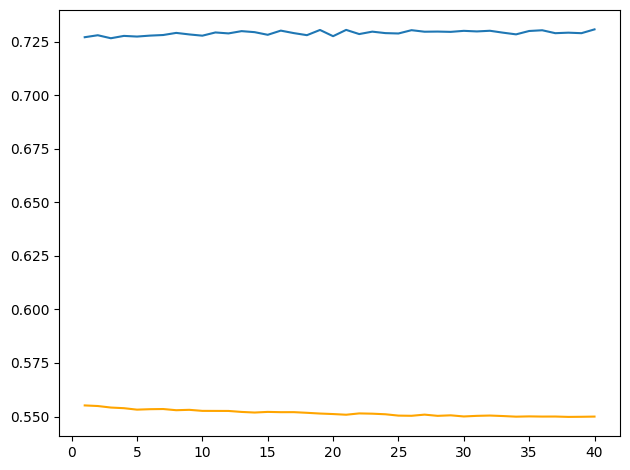

In [36]:
# Create a DataFrame containing training history
history_df = pd.DataFrame(top_model_c.history)

# Increase the index by 1 to match the number of epochs
history_df.index += 1

fig, ax1 = plt.subplots()
# Plot the loss
ax1.plot(history_df["loss"], label='loss', color='orange')
# Plot the accuracy
ax1.plot(history_df["accuracy"], label='accuracy')
plt.tight_layout()
plt.show()

In [41]:
# Export our model to HDF5 file
top_model.save("AlphabetSoupCharity_Optimization_Accuracy_738.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [37]:
# Try to build the above model using found hyperparameters
# Define hyperparameters
n_layers=params['num_layers']
n_units=[]
n_units.append(params['first_units'])
for i in range(1,n_layers):
    u_label='units_'+str(i)
    n_units.append(params[u_label])
activation_f=params['activation']
print(n_layers)
print(n_units)

3
[20, 26, 1]


In [38]:
#Set-up a model using found hyperparameters
nn = tf.keras.models.Sequential()
nn.add(tf.keras.layers.Input(shape=(n_input_features,)))

# add all the layers (including input, hidden and final)
for i in range(0,n_layers-1):
    nn.add(tf.keras.layers.Dense(n_units[i], activation=activation_f))
nn.add(tf.keras.layers.Dense(1, activation='sigmoid'))

# Check the structure of the model
nn.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 20)                720       
                                                                 
 dense_5 (Dense)             (None, 26)                546       
                                                                 
 dense_6 (Dense)             (None, 1)                 27        
                                                                 
Total params: 1293 (5.05 KB)
Trainable params: 1293 (5.05 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [39]:
# Compile the model
nn.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [40]:
# Train the model
nn_model=nn.fit(X_train_scaled, y_train, epochs=40, verbose=0)


In [42]:
# Evaluate the model using the test data
model_loss, model_accuracy = nn.evaluate(X_test_scaled,y_test,verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

215/215 - 0s - loss: 0.5501 - accuracy: 0.7345 - 376ms/epoch - 2ms/step
Loss: 0.550130307674408, Accuracy: 0.7345480918884277


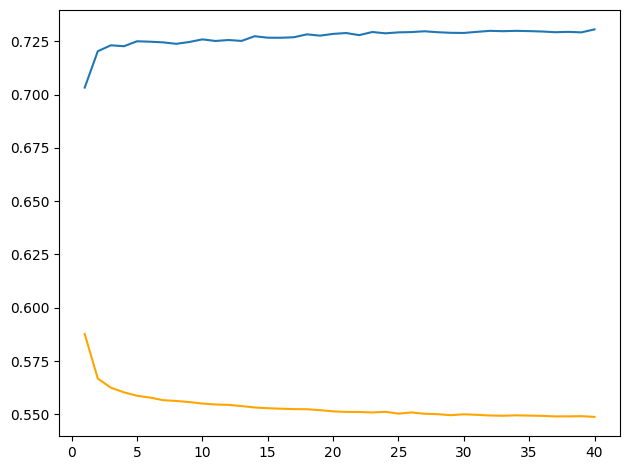

In [43]:
# Create a DataFrame containing training history
history_df = pd.DataFrame(nn_model.history)

# Increase the index by 1 to match the number of epochs
history_df.index += 1

fig, ax1 = plt.subplots()
# Plot the loss
ax1.plot(history_df["loss"], label='loss', color='orange')
# Plot the accuracy
ax1.plot(history_df["accuracy"], label='accuracy')
plt.tight_layout()
plt.show()

In [44]:
# Experiment with params

In [45]:
nn2 = tf.keras.models.Sequential()
nn2.add(tf.keras.layers.Input(shape=(n_input_features,)))

# all the layers (including input, hidden)
nn2.add(tf.keras.layers.Dense(30, activation='tanh'))
nn2.add(tf.keras.layers.Dense(16, activation='tanh'))
nn2.add(tf.keras.layers.Dense(1, activation='sigmoid'))

# Check the structure of the model
nn2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_7 (Dense)             (None, 30)                1080      
                                                                 
 dense_8 (Dense)             (None, 16)                496       
                                                                 
 dense_9 (Dense)             (None, 1)                 17        
                                                                 
Total params: 1593 (6.22 KB)
Trainable params: 1593 (6.22 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [49]:
# Compile the model
nn2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
# Train the model
nn_model_c=nn2.fit(X_train_scaled, y_train, epochs=135, verbose=0)
# Evaluate the model using the test data
model_loss, model_accuracy = nn2.evaluate(X_test_scaled,y_test,verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

215/215 - 1s - loss: 0.5465 - accuracy: 0.7332 - 545ms/epoch - 3ms/step
Loss: 0.5465250611305237, Accuracy: 0.7332361340522766


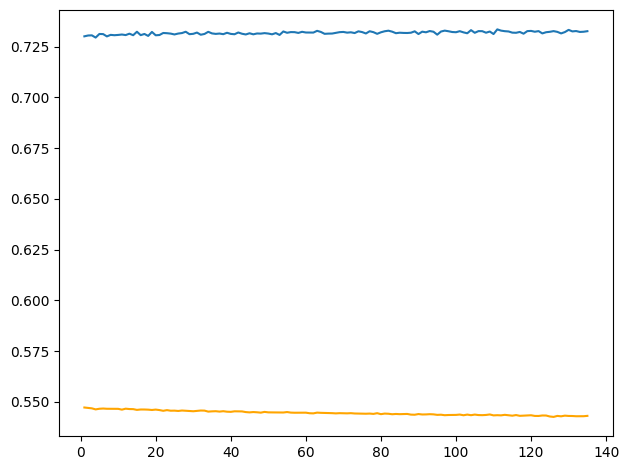

In [50]:
# Create a DataFrame containing training history
history_df = pd.DataFrame(nn_model_c.history)

# Increase the index by 1 to match the number of epochs
history_df.index += 1

fig, ax1 = plt.subplots()
# Plot the loss
ax1.plot(history_df["loss"], label='loss', color='orange')
# Plot the accuracy
ax1.plot(history_df["accuracy"], label='accuracy')
plt.tight_layout()
plt.show()